In [2]:
import numpy as np
import matplotlib.pyplot as plt

from FNO import FNO1d
from save_result import Model_Result

import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm


/tmp/ipykernel_1273278/2679469314.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Pulse Data

### Data Prep

In [2]:
skip = 5
samples = 500
x = np.genfromtxt('pulse_data/time.csv', delimiter=',')[0][::skip]
train_x = np.genfromtxt('pulse_data/train_x.csv', delimiter=',', skip_header=1)[:samples, np.newaxis, ::skip]
train_y = np.genfromtxt('pulse_data/train_y.csv', delimiter=',', skip_header=1)[:samples, np.newaxis, ::skip]
test_x = np.genfromtxt('pulse_data/test_x.csv', delimiter=',', skip_header=1)[:, np.newaxis, ::skip]
test_y = np.genfromtxt('pulse_data/test_y.csv', delimiter=',', skip_header=1)[:, np.newaxis, ::skip]

print("x shape:", x.shape)
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)

# ===========================
# Normalize train_x and test_x
# ===========================
x_max = train_x.max()

train_x_norm = train_x / x_max
test_x_norm = test_x / x_max  # use train stats

# ===========================
# Normalize train_y and test_y
# ===========================
y_max = train_y.max()

train_y_norm = train_y / y_max
test_y_norm = test_y / y_max  # use train stats

x shape: (401,)
train_x shape: (500, 1, 401)
train_y shape: (500, 1, 401)
test_x shape: (500, 1, 401)
test_y shape: (500, 1, 401)


In [133]:
fno = FNO1d(
    1,
    1,
    16,
    8,
    activation = jax.nn.tanh,
    n_blocks = 4,
    key=jax.random.PRNGKey(0),
)

### FNO Training

In [134]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [135]:
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

optimizer = optax.adam(5e-3)
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))

@eqx.filter_jit
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x, test_y)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(200)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x,
        train_y,
        batch_size=50,
    ):
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

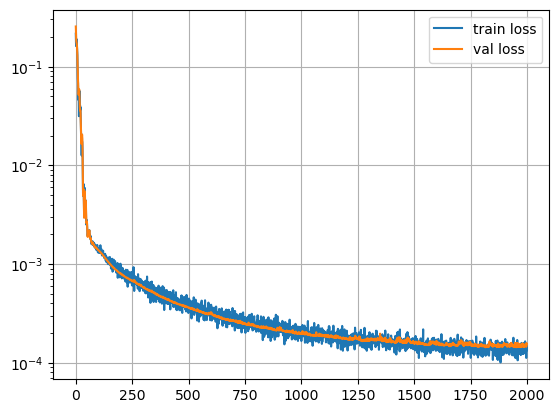

In [136]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

#### Prediction on Training Set

In [137]:
# fig, axes = plt.subplots(10, 10, figsize=(20, 20))
# axes = axes.flatten()
# for i in range(100):
#     pred = fno(train_x[i, :, :])[0]
#     ax1 = axes[i]
    
#     ax1.plot(train_y[i, 0, :], color='tab:orange', label='Ground Truth')
#     ax1.plot(pred, color='tab:green', label='Prediction')
    

# # Show legends only once to avoid clutter
# lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0], axes[0].twinx()]]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, loc='upper center', ncol=3)

# plt.tight_layout()
# plt.show()

#### Prediction on Test Set

In [138]:
# fig, axes = plt.subplots(10, 10, figsize=(20, 20))
# axes = axes.flatten()
# for i in range(100):
#     pred = fno(test_x[i, :, :])[0]
#     ax1 = axes[i]
    
#     ax1.plot(test_y[i, 0, :], color='tab:orange', label='Ground Truth')
#     ax1.plot(pred, color='tab:green', label='Prediction')
    

# # Show legends only once to avoid clutter
# lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0], axes[0].twinx()]]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, loc='upper center', ncol=3)

# plt.tight_layout()
# plt.show()

#### Pulse Response

In [139]:
from ipywidgets import interact, IntSlider

def impulse_response_N(N):
    time = np.linspace(0,200,N)
    impulse = np.zeros(N)
    impulse[0] = 1

    impulse = impulse.reshape(1,-1)[:,np.newaxis,:]
    pred = fno(impulse[0,:,:])[0]
    plt.plot(time, pred)
    plt.show

# Define slider widget for number of frequencies kept
slider = IntSlider(min=10, max=10000, step=10, value=1000, description='N')

# Launch interactive plot
interact(impulse_response_N, N=slider)


interactive(children=(IntSlider(value=1000, description='N', max=10000, min=10, step=10), Output()), _dom_clas…

<function __main__.impulse_response_N(N)>

In [140]:
time = np.genfromtxt('pulse_data/time.csv', delimiter=',')[0][::2]
impulse = np.zeros_like(time)
impulse[0] = 1
impulse = impulse.reshape(1,-1)

impulse = impulse[:,np.newaxis,:]
print(impulse.shape)

pred = fno(impulse[0,:,:])[0]


(1, 1, 1001)


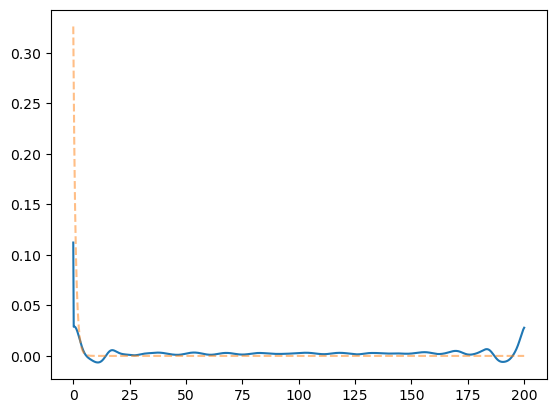

In [141]:
dt = time[1] - time[0]
plt.plot(time, pred)
plt.plot(time, np.exp(-time+1)*0.12, linestyle='dashed',alpha = 0.5)

#### Out of Dist Functions

In [142]:
# outOfDist_x = np.genfromtxt('pulse_data/outOfDist_x.csv', delimiter=',', skip_header=1)[:,np.newaxis,::2]
# outOfDist_y = np.genfromtxt('pulse_data/outOfDist_y.csv', delimiter=',', skip_header=1)[:,np.newaxis,::2]

# outOfDist_x.shape, outOfDist_y.shape

In [143]:
# fig, axes = plt.subplots(10, 10, figsize=(20, 20))
# axes = axes.flatten()
# for i in range(100):
#     pred = fno(outOfDist_x[i, :, :])[0]
#     ax1 = axes[i]
    
#     ax1.plot(outOfDist_y[i, 0, :], color='tab:orange', label='Ground Truth')
#     ax1.plot(pred, color='tab:green', label='Prediction', alpha = 0.5)
    

# # Show legends only once to avoid clutter
# lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0], axes[0].twinx()]]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, loc='upper center', ncol=3)

# plt.tight_layout()
# plt.show()

#### Save Model

In [144]:
fno_result = Model_Result(fno, loss_history, val_loss_history, 'pulse')

In [145]:
fno_result.save()

## Friction Data

In [3]:
feature = np.genfromtxt('friction_data/features.csv', delimiter=',')[:, np.newaxis,:]
target = np.genfromtxt('friction_data/targets_SlipLaw.csv', delimiter=',')[:, np.newaxis,:]
t = np.linspace(0,1,feature.shape[2])

print("t shape:", t.shape)
print("feature shape:", feature.shape)
print("target shape:", target.shape)


train_x = feature[:750,:,:]
train_y = target[:750,:,:]
test_x = feature[750:,:,:]
test_y = target[750:,:,:]

print("train_x shape:" , train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)


# ===========================
# Normalize train_x and test_x
# ===========================
x_max = train_x.max()

train_x_norm = np.log(np.log(1/train_x))
test_x_norm = np.log(np.log(1/test_x))

# ===========================
# Normalize train_y and test_y
# ===========================
y_max = train_y.max()

train_y_norm = train_y /y_max
test_y_norm = test_y / y_max # use train stats

t shape: (250,)
feature shape: (1000, 1, 250)
target shape: (1000, 1, 250)
train_x shape: (750, 1, 250)
train_y shape: (750, 1, 250)
test_x shape: (250, 1, 250)
test_y shape: (250, 1, 250)


In [4]:
# Make sure your datasets are numpy arrays initially; convert to jnp arrays here:
train_x_norm = jnp.array(train_x_norm)
train_y_norm = jnp.array(train_y_norm)
test_x_norm = jnp.array(test_x_norm)
test_y_norm = jnp.array(test_y_norm)

# Dataloader unchanged
def dataloader(key, dataset_x, dataset_y, batch_size):
    n_samples = dataset_x.shape[0]
    n_batches = int(jnp.ceil(n_samples / batch_size))
    permutation = jax.random.permutation(key, n_samples)
    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)
        batch_indices = permutation[start:end]
        yield dataset_x[batch_indices], dataset_y[batch_indices]

# Loss function unchanged
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

# Learning rate schedule
init_lr = 5e-3
lr_schedule = optax.exponential_decay(
    init_value=init_lr,
    transition_steps=1000,
    decay_rate=0.95,
    staircase=True,
)

optimizer = optax.adam(lr_schedule)

# JIT-compiled step function, no manual step passing
@eqx.filter_jit
def make_step(model, opt_state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x_norm, test_y_norm)
    updates, new_opt_state = optimizer.update(grad, opt_state, params=model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_opt_state, loss, val_loss

# Initialize your model
fno_friction = FNO1d(
    1,
    1,
    12,
    32,
    jax.nn.gelu,
    4,
    9,
    key=jax.random.PRNGKey(0),
)

opt_state = optimizer.init(eqx.filter(fno_friction, eqx.is_array))

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)

for epoch in tqdm(range(500)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for batch_x, batch_y in dataloader(subkey, train_x_norm, train_y_norm, batch_size=32):
        fno_friction, opt_state, loss, val_loss = make_step(fno_friction, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

# Optional: check devices to confirm GPU usage
print("JAX devices:", jax.devices())


  0%|          | 0/500 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [49]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

@eqx.filter_jit
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x_norm, test_y_norm)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

In [50]:
# modes = [16,32,64]
# widths = [1,4,16,64]
# activation_funcs = [None, jax.nn.tanh, jax.nn.relu]
# blocks = [1,2,4,8]

# for mode in modes:
#     for width in widths:
#         for activation_func in activation_funcs:
#             for block in blocks:
#                 fno_friction = FNO1d(
#                     1,
#                     1,
#                     mode,
#                     width,
#                     activation_func,
#                     block,
#                     key=jax.random.PRNGKey(0),
#                 )

#                 optimizer = optax.adam(5e-3)
#                 opt_state = optimizer.init(eqx.filter(fno_friction, eqx.is_array))

#                 loss_history = []
#                 val_loss_history = []

#                 shuffle_key = jax.random.PRNGKey(10)
#                 for epoch in tqdm(range(100)):
#                     shuffle_key, subkey = jax.random.split(shuffle_key)
#                     for (batch_x, batch_y) in dataloader(
#                         subkey,
#                         train_x_norm,
#                         train_y_norm,
#                         batch_size=100,
#                     ):
#                         fno_friction, opt_state, loss, val_loss = make_step(fno_friction, opt_state, batch_x, batch_y)
#                         loss_history.append(loss)
#                         val_loss_history.append(val_loss)

#                 fno_result = Model_Result(fno_friction, loss_history, val_loss_history, 'friction')
#                 fno_result.save()

fno_friction = FNO1d(
                    1,
                    1,
                    12,
                    32,
                    jax.nn.gelu,
                    8,
                    9,
                    key=jax.random.PRNGKey(0),
                )

optimizer = optax.adam(5e-3)
opt_state = optimizer.init(eqx.filter(fno_friction, eqx.is_array))

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(50)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x_norm,
        train_y_norm,
        batch_size=100,
    ):
        fno_friction, opt_state, loss, val_loss = make_step(fno_friction, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

#fno_result = Model_Result(fno_friction, loss_history, val_loss_history, 'friction')
#fno_result.save()

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Training Loop

In [ ]:
# optimizer = optax.adam(5e-3)
# opt_state = optimizer.init(eqx.filter(fno_friction, eqx.is_array))

# loss_history = []
# val_loss_history = []

# shuffle_key = jax.random.PRNGKey(10)
# for epoch in tqdm(range(100)):
#     shuffle_key, subkey = jax.random.split(shuffle_key)
#     for (batch_x, batch_y) in dataloader(
#         subkey,
#         train_x_norm,
#         train_y_norm,
#         batch_size=100,
#     ):
#         fno_friction, opt_state, loss, val_loss = make_step(fno_friction, opt_state, batch_x, batch_y)
#         loss_history.append(loss)
#         val_loss_history.append(val_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

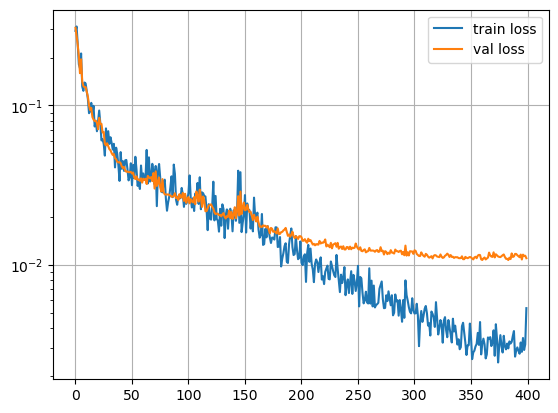

In [ ]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

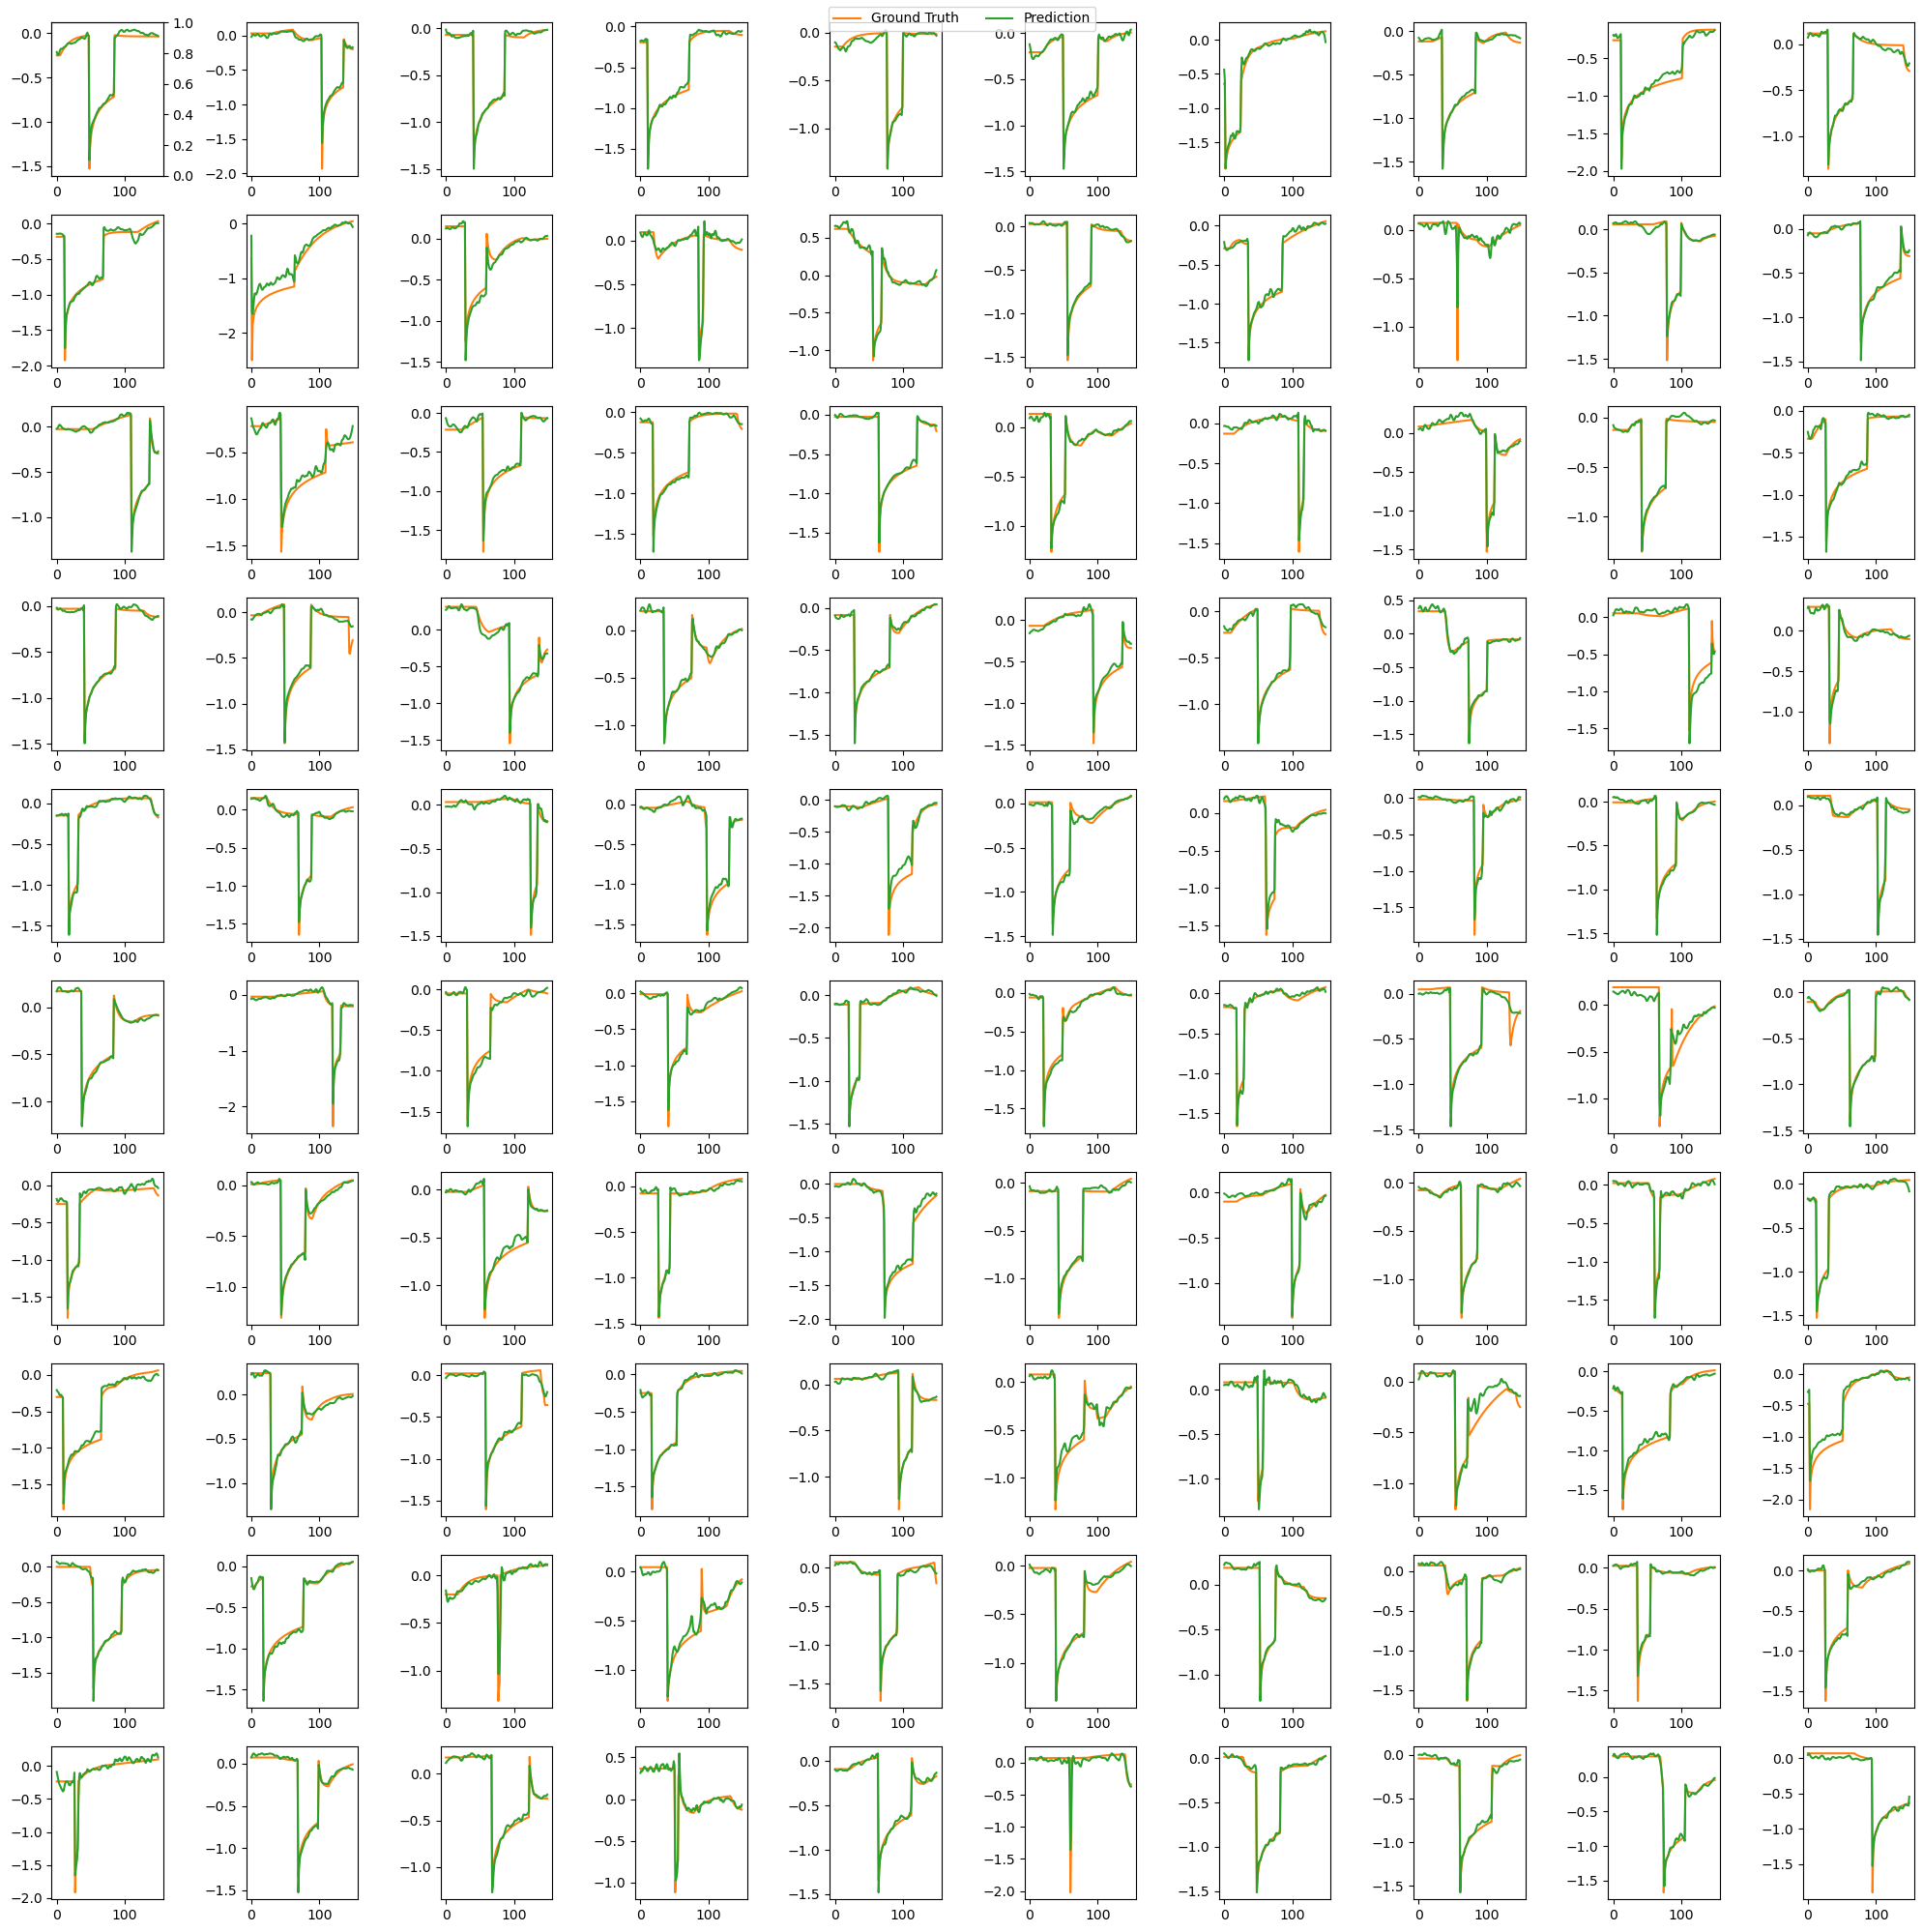

In [46]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()
for i in range(100):
    pred = fno_friction(train_x_norm[i, :, :])[0]
    ax1 = axes[i]
    
    ax1.plot(train_y_norm[i, 0, :], color='tab:orange', label='Ground Truth')
    ax1.plot(pred, color='tab:green', label='Prediction')
    

# Show legends only once to avoid clutter
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0], axes[0].twinx()]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=3)

plt.tight_layout()
plt.show()

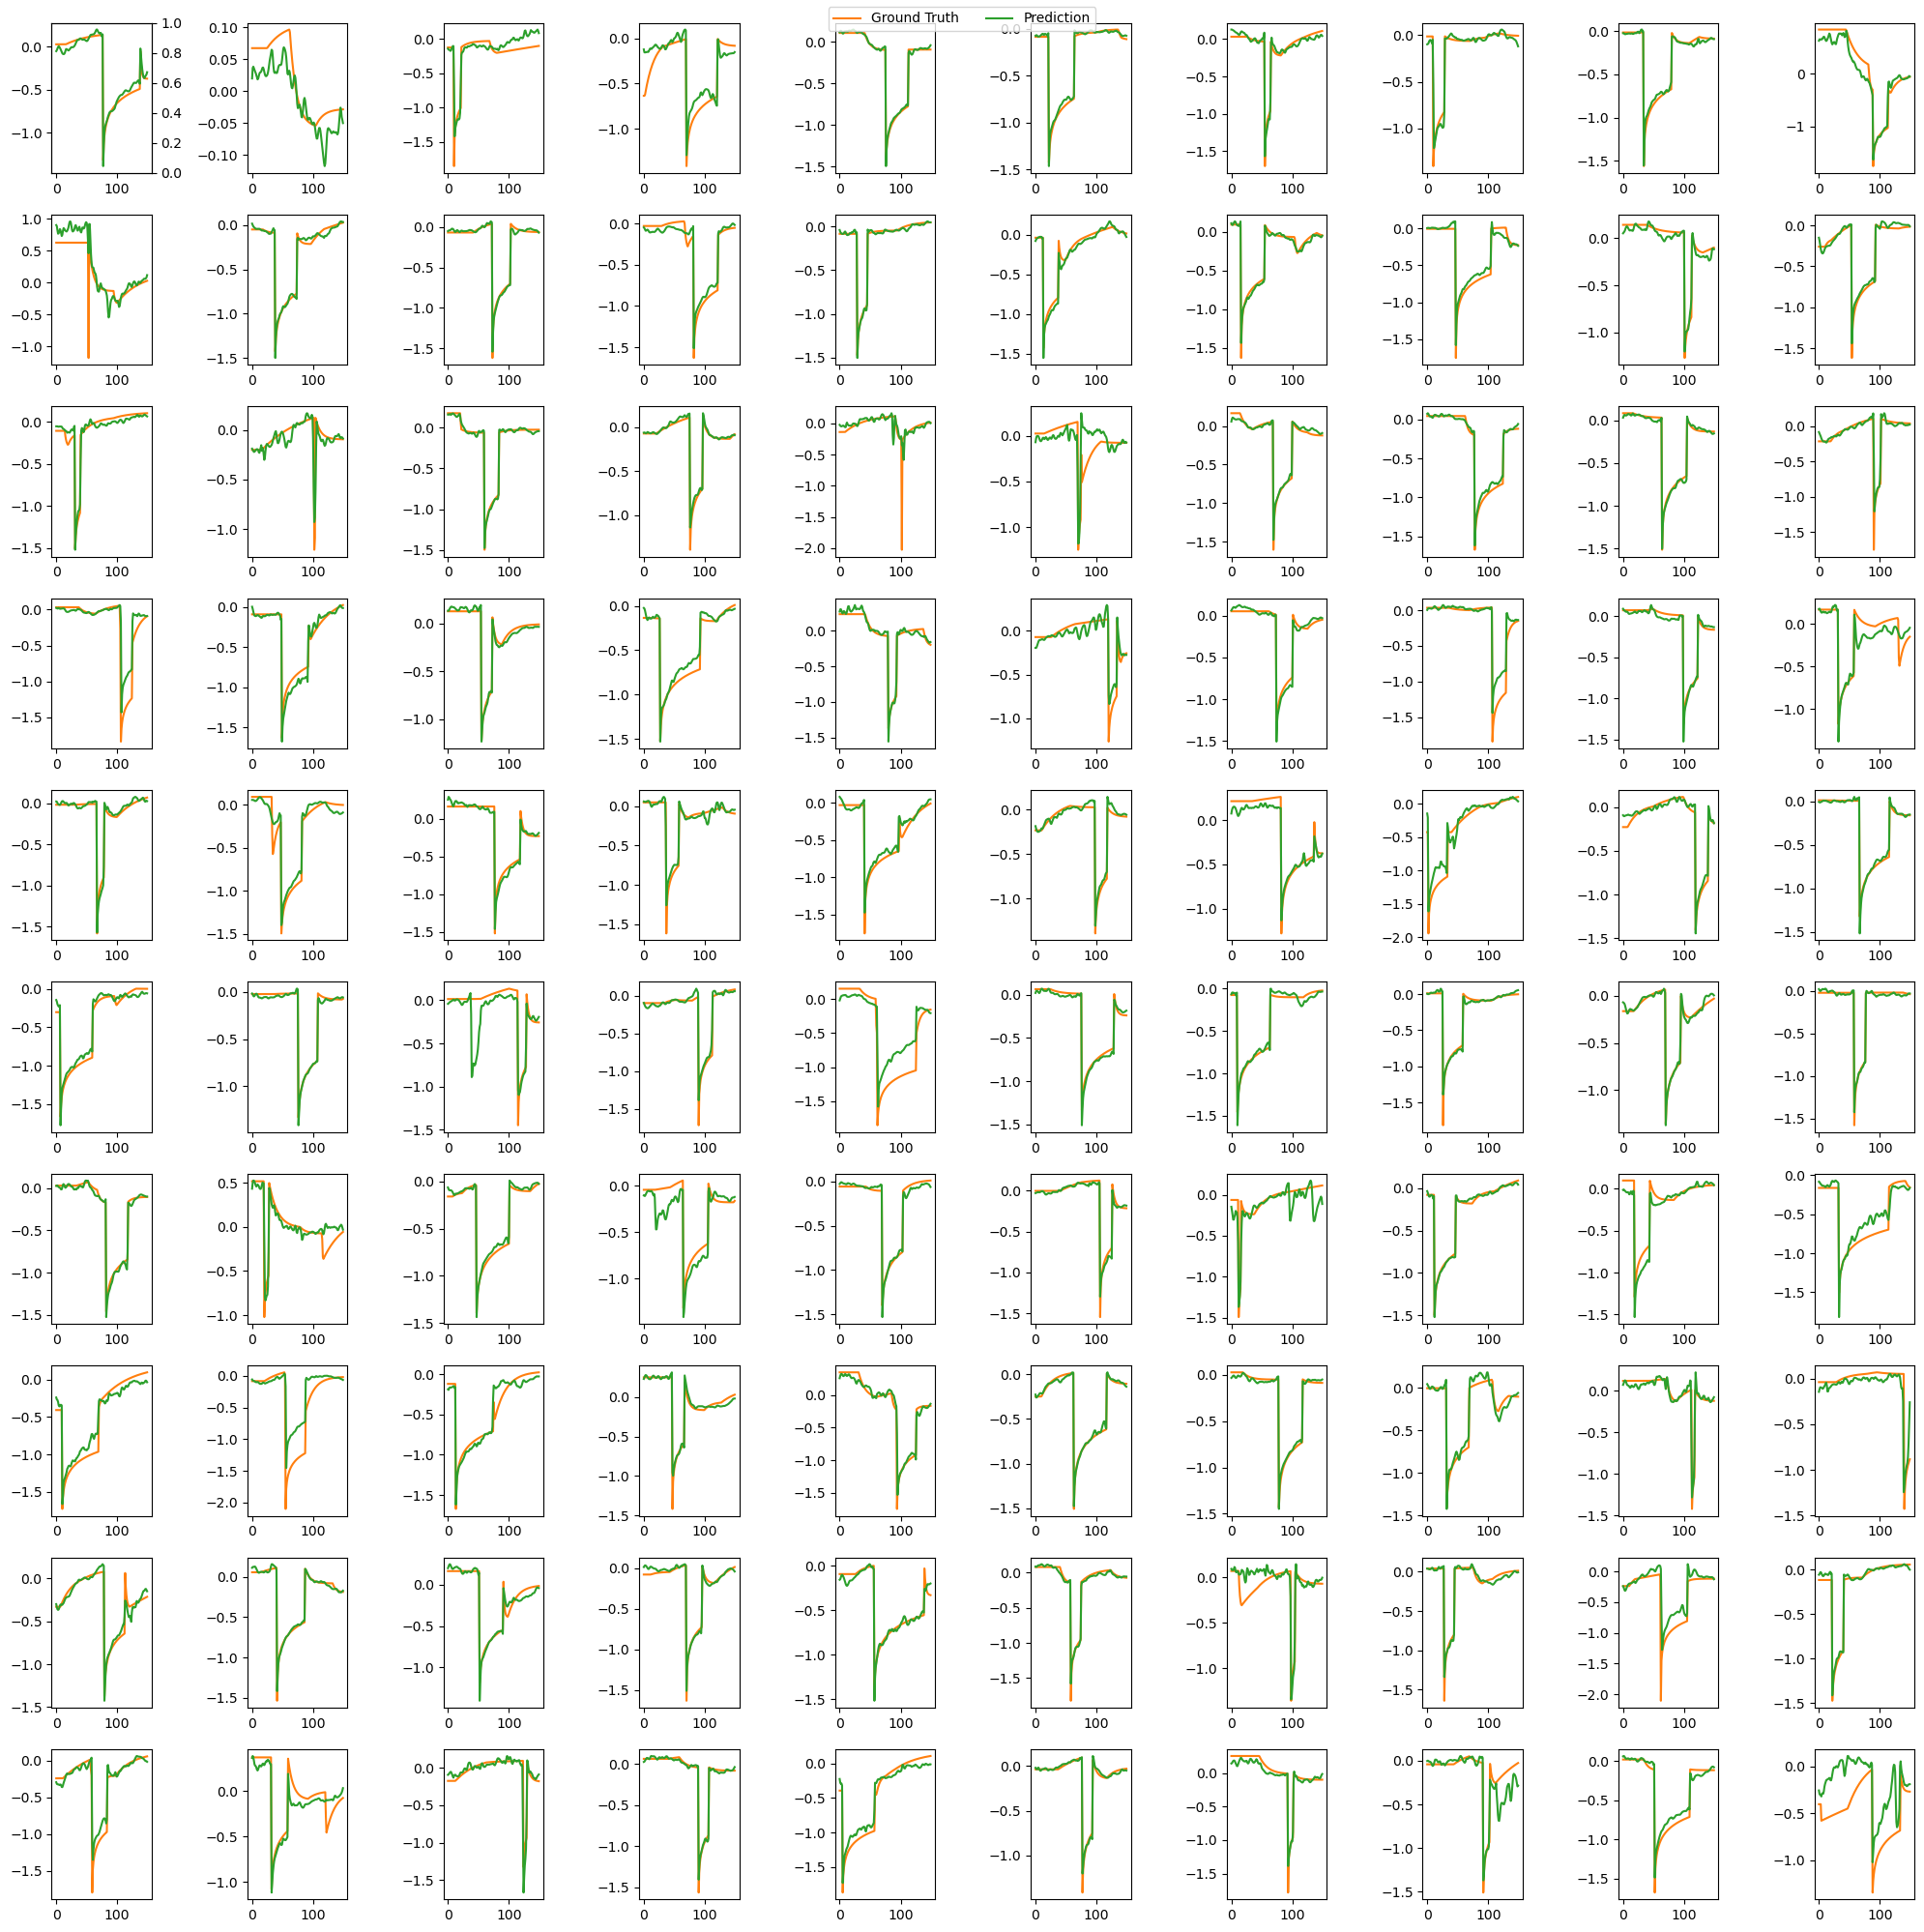

In [47]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()
for i in range(100):
    pred = fno_friction(test_x_norm[i, :, :])[0]
    ax1 = axes[i]
    
    ax1.plot(test_y_norm[i, 0, :], color='tab:orange', label='Ground Truth')
    ax1.plot(pred, color='tab:green', label='Prediction')
    

# Show legends only once to avoid clutter
lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0], axes[0].twinx()]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=3)

plt.tight_layout()
plt.show()